In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import html
import re
from typing import List
import pandas as pd
import spacy
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import trange

from utils import get_console, print_html, print_json
# Initialise a rich console with custom theme
console = get_console()

## Load, Preprocess, and Parse Ads

In [3]:
# Load dataset
ads_df: pd.DataFrame = pd.read_json("./data/ads-50k.json", lines=True)
print(f"DataFrame object shape: {ads_df.shape}")
ads_df.head() 

DataFrame object shape: (50000, 5)


,id,title,abstract,content,metadata
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,<HTML><p>Are you looking to join a thriving bu...,{'standout': {'bullet1': 'Join a Sector that i...
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,<HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...,{'additionalSalaryText': 'Attractive Commissio...
2,38946054,Senior Developer | SA,Readifarians are known for discovering the lat...,<HTML><p>Readify helps organizations innovate ...,"{'standout': {'bullet1': 'Design, develop, tes..."
3,38833950,Senior Commercial Property Manager | Leading T...,~ Rare opportunity for a Senior PM to step int...,<HTML><p><strong>WayPoint Recruitment&nbsp;</s...,{'additionalSalaryText': '$140k + Car Park - C...
4,38856271,Technology Manager | Travel Industry,Rare opportunity for an experienced Technology...,<HTML>This is a key role within a market leadi...,{'standout': {'bullet1': 'Lead overarching str...


In [4]:
# Explore the metadata column
for i in range(3):
    print_json(ads_df["metadata"].iloc[i], indent=2, console=console)

{
  "standout": {
    "bullet1": "Join a Sector that is considered Recession Proof !",
    "bullet2": "Excellent opportunity  for Career Progression within a Global Organisation",
    "bullet3": "Make a Diference whilst earning Money and having Fun"
  },
  "additionalSalaryText": "commission",
  "classification": {
    "name": "Education & Training"
  },
  "subClassification": {
    "name": "Other"
  },
  "location": {
    "name": "Sydney"
  },
  "workType": {
    "name": "Full Time"
  }
}

{
  "additionalSalaryText": "Attractive Commission - Uncapped Earning Potential",
  "classification": {
    "name": "Retail & Consumer Products"
  },
  "subClassification": {
    "name": "Retail Assistants"
  },
  "area": {
    "name": "Northern Suburbs"
  },
  "location": {
    "name": "Melbourne"
  },
  "suburb": {
    "name": "Coburg"
  },
  "workType": {
    "name": "Casual/Vacation"
  }
}

{
  "standout": {
    "bullet1": "Design, develop, test and deliver custom software solutions",
    "bullet2": "Keep your skills current with 20 x paid professional development days per year",
    "bullet3": "Flexible & inclusive work environment"
  },
  "classification": {
    "name": "Information & Communication Technology"
  },
  "subClassification": {
    "name": "Consultants"
  },
  "location": {
    "name": "Adelaide"
  },
  "workType": {
    "name": "Full Time"
  }
}

#### Key insights - Metadata
* It seems like the `classification` key provides a higher level of granularity and can be understood as the theme of a job.
* Like `classification`, the `sub-classification` key is just one level lower for the theme/type of the job. 
* I will also extract the `location` of the ad as it is usually a good idea to maintain for metadata in GenAI solutions.

In [5]:
# Adding columns and exploring the amount of unique items in the column
ads_df["theme"] = ads_df["metadata"].apply(lambda x: x["classification"]["name"])
ads_df["sub_theme"] = ads_df["metadata"].apply(lambda x: x["subClassification"]["name"])
ads_df["job_location"] = ads_df["metadata"].apply(lambda x: x["location"]["name"])

print(
    f"Parent grouping size: {ads_df["theme"].nunique():,}" \
    f"\nSub classification size: {ads_df["sub_theme"].nunique():,}" \
    f"\nTitles size: {ads_df["title"].nunique():,}"  
)
display(ads_df.head())

Parent grouping size: 30
Sub classification size: 337
Titles size: 36,207


,id,title,abstract,content,metadata,theme,sub_theme,job_location
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,<HTML><p>Are you looking to join a thriving bu...,{'standout': {'bullet1': 'Join a Sector that i...,Education & Training,Other,Sydney
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,<HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...,{'additionalSalaryText': 'Attractive Commissio...,Retail & Consumer Products,Retail Assistants,Melbourne
2,38946054,Senior Developer | SA,Readifarians are known for discovering the lat...,<HTML><p>Readify helps organizations innovate ...,"{'standout': {'bullet1': 'Design, develop, tes...",Information & Communication Technology,Consultants,Adelaide
3,38833950,Senior Commercial Property Manager | Leading T...,~ Rare opportunity for a Senior PM to step int...,<HTML><p><strong>WayPoint Recruitment&nbsp;</s...,{'additionalSalaryText': '$140k + Car Park - C...,Real Estate & Property,"Commercial Sales, Leasing & Property Mgmt",Melbourne
4,38856271,Technology Manager | Travel Industry,Rare opportunity for an experienced Technology...,<HTML>This is a key role within a market leadi...,{'standout': {'bullet1': 'Lead overarching str...,Information & Communication Technology,Management,Auckland


As expected there are significantly more titles then there are `theme` or `sub-theme`, let's see the describution of job titles across themes

In [6]:
# Exploring top 10 themes
ads_df["title"].value_counts(normalize=True).iloc[:10]

title
Project Manager                    0.00388
Business Development Manager       0.00300
Registered Nurse                   0.00234
Business Analyst                   0.00208
Executive Assistant                0.00186
Payroll Officer                    0.00178
Recruitment Consultant             0.00168
Accounts Payable Officer           0.00166
Customer Service Representative    0.00166
Receptionist                       0.00162
Name: proportion, dtype: float64

10% of the dataset contains `Information & Communication Technology` ads  

In [7]:
# Top 10 titles
ads_df["title"].value_counts(normalize=True).iloc[:10]

title
Project Manager                    0.00388
Business Development Manager       0.00300
Registered Nurse                   0.00234
Business Analyst                   0.00208
Executive Assistant                0.00186
Payroll Officer                    0.00178
Recruitment Consultant             0.00168
Accounts Payable Officer           0.00166
Customer Service Representative    0.00166
Receptionist                       0.00162
Name: proportion, dtype: float64

## Parsing Job Ads

In [8]:
# Exploring the html object (I have explored the first 5 ads and concluded that it will be more scalable to parse ads with regex, html, and BeautifulSoup)
print_html(ads_df["content"].iloc[3], console)

<html>
 <p>
  <strong>
   WayPoint Recruitment
  </strong>
  have partnered up with a respected Commercial Real Estate agency. With strong growth in the last 12 months, this 
 </p>
 <p>
  <strong>
   About the Role:
  </strong>
  <br/>
  • Day to day management of an extremely tidy portfolio (minimal maintenance, due to long-term leases in place)
  <br/>
  • 160 Tenancies - Retail, Office &amp; Medical
  <br/>
  • Manage existing long-term tenant and landlord relationships
  <br/>
  • Ensure outgoings are managed and delivered through to payment
 </p>
 <p>
  <br/>
  <strong>
   About the Company:
  </strong>
  <br/>
  • The Company has achieved strong growth in the last 12 months and are market leaders in Melbourne
  <br/>
  • No Leasing and full-time support from an Assistant PM
  <br/>
  • The company has many departments, structured from Property Management, Sales and Leasing
  <br/>
  • A family feel environment as well as being supported in your career goals and ambitions
  <br/>
  <br/>
  <strong>
   Skills and Experience you will need:
  </strong>
 </p>
 <p>
  • A genuine interest for the Commercial Property industry &amp; able to work well in a team
  <br/>
  • A minimum of 3 years' experience Managing a Commercial portfolio
  <br/>
  • Strong communication (verbal and written), professional presentation and a positive attitude
  <br/>
  • Valid Agent Rep and drivers licence
 </p>
 <p>
  <br/>
  If you're interested in further discussing this opportunity or other Property Management roles WayPoint Recruitme
  <strong>
   James Calleja
  </strong>
  on
  <strong>
   0430 058 777
  </strong>
  alternatively email
  <strong>
   james@waypointrecruitment.com.au
  </strong>
  or visit
  <strong>
   <em>
    www.waypointrecruitment.com.au
   </em>
  </strong>
 </p>
</html>

In [9]:
# Compile patterns
pattern = r"(?:[ \t]*\n){2,}" #? Pattern to find multiple blank lines (at least 2)
p_compiled = re.compile(pattern, flags=re.DOTALL)


def clean_html(html_content: str) -> str:
    """Extract and clean text from a single HTML string."""
    soup = BeautifulSoup(html_content, 'html.parser')
    html_text = soup.get_text(separator="\n") # Extract text from HTML
    text = html.unescape(html_text).replace("\xa0", " ").strip() # normalise spaces
    clean_text = p_compiled.sub("\n\n", text)  # collapse multiple blank lines
    clean_text = clean_text.replace("\n ", "\n") # remove extra space after newlines
    return clean_text


def get_text_batch(df: pd.DataFrame, batch_size: int = 1000) -> pd.Series:
    """Parsing ads in batches (applying clean_html)"""
    all_texts = []
    for i in trange(0, len(df), batch_size):
        batch = df["content"].iloc[i:i+batch_size]
        for html_content in batch:
            all_texts.append(clean_html(html_content))
    return pd.Series(all_texts)

# Parsing the text - replacing the current "content column"
ads_df["content"] = get_text_batch(ads_df)

100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [10]:
# Now that metadata extracted, we don't need the "abstract" column and the "metadata" columns so we will remove them 
redundant_columns: List[str] = ["abstract", "metadata"]
ads_df: pd.DataFrame = ads_df.drop(columns=redundant_columns)
ads_df.head()

,id,title,content,theme,sub_theme,job_location
0,38915469,Recruitment Consultant,Are you looking to join a thriving business th...,Education & Training,Other,Sydney
1,38934839,Computers Salesperson - Coburg,· Casual hours as required (transition to Par...,Retail & Consumer Products,Retail Assistants,Melbourne
2,38946054,Senior Developer | SA,Readify helps organizations innovate with tech...,Information & Communication Technology,Consultants,Adelaide
3,38833950,Senior Commercial Property Manager | Leading T...,WayPoint Recruitment \nhave partnered up with ...,Real Estate & Property,"Commercial Sales, Leasing & Property Mgmt",Melbourne
4,38856271,Technology Manager | Travel Industry,This is a key role within a market leading Tra...,Information & Communication Technology,Management,Auckland


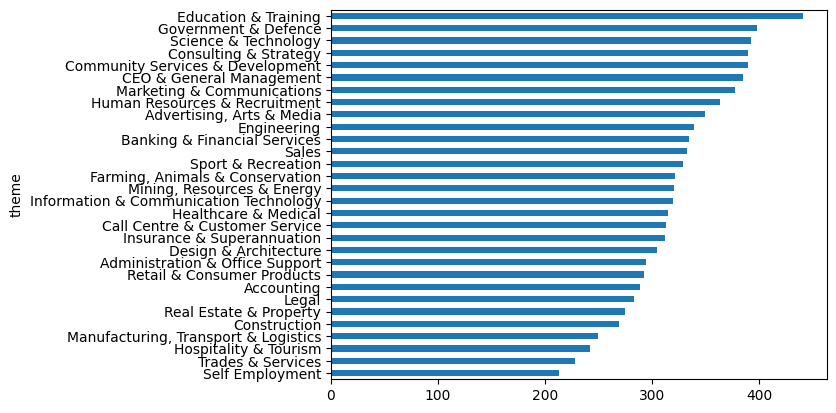

In [11]:
# Exploring the quality of job ads - how many words appear on average per theme? 
(
    ads_df.assign(
        word_count=ads_df["content"].apply(lambda text: len(text.split()))
    ).groupby("theme", group_keys=True)
    ["word_count"].mean().round().sort_values()
    .plot.barh()
);

In [40]:
(
    ads_df.assign(
        word_count=ads_df["content"].apply(lambda text: len(text.split()))
    )[["theme", "content", "word_count"]]
    .sort_values(by="word_count")
    .head(30)
)

,theme,content,word_count
40243,Information & Communication Technology,,0
26206,Sales,POSITION PENDING,2
28131,Human Resources & Recruitment,.\n\n.,2
12354,"Mining, Resources & Energy",No add required,3
40290,Trades & Services,Truck and Trailer experience required,5
32774,Trades & Services,Bricklayer needed for work around Sydney,6
26164,"Manufacturing, Transport & Logistics",GRADER OPERATOR\nNEEDED\nPlease call:\n0419 68...,8
11146,"Mining, Resources & Energy",Shot Firers | 2:1 FIFO for an Immediate Start,9
17107,Trades & Services,TOWNSVILLE\nTEXTURE COATING\nRender/Texture Co...,10
31600,Hospitality & Tourism,bar staff casual 2 nights per week no experien...,10


> As per the above, we can see that job advertisement in the **low end have ~200-250 words on average**, where as in the high end job advertisements have **~350-400+ words on average**. 
>Further, whilst some of the job ads contain only 5+ words `skills` / `responsibilities` / `requirements` can potentially be extracted or infered from the context, therefor we won't remove these job ads. We can just remove the first 4 values from the table above, let's do that

In [44]:
# Removing the first 4 
ads_df = ads_df.loc[~ads_df.index.isin([40243, 26206, 28131, 12354])]
console.print(ads_df.shape)
ads_df.head()

(49996, 6)

,id,title,content,theme,sub_theme,job_location
0,38915469,Recruitment Consultant,Are you looking to join a thriving business th...,Education & Training,Other,Sydney
1,38934839,Computers Salesperson - Coburg,· Casual hours as required (transition to Par...,Retail & Consumer Products,Retail Assistants,Melbourne
2,38946054,Senior Developer | SA,Readify helps organizations innovate with tech...,Information & Communication Technology,Consultants,Adelaide
3,38833950,Senior Commercial Property Manager | Leading T...,WayPoint Recruitment \nhave partnered up with ...,Real Estate & Property,"Commercial Sales, Leasing & Property Mgmt",Melbourne
4,38856271,Technology Manager | Travel Industry,This is a key role within a market leading Tra...,Information & Communication Technology,Management,Auckland


## TF IDF & POS

##### **Soft-skills**
We can use `spacy` to load a pre-trained language model to both pre-process and tag single words within a job advertisement using `POS` (part of speech tagging). <br> Usually, and as an assumption, soft-skills can be described as a pair of `ADJ` and `NOUN` as:  
* `ADJ` is a word that describes or modifies the `NOUN` → "_strong (ADJ) communication (NOUN)_" == **Soft-skill**
* `NOUN` is a "thing" such as a person, place, thing, or concept.  

However, the above rule isn’t always true as soft-skills can also be simply represented as `NOUNS` (i.e. _"leadership"_) or `VERBS` (i.e. _"Collaborate"_)

##### **Hard skills**
Hard skills, however, can be understood as `PROPN` proper nouns since they are assigned to specific tools, for example "Python". Here, as well, this rule isn’t always correct — hard skills too can be represented as `NOUNS` (i.e. _"databases"_, _"statistics"_, etc.).

##### **TF IDF APPROACH**
Filter the `content` to `ADJ`, `NOUN` and `PROPN` to find the top N terms (skills/soft-skills) from the content column. To quantify the approach I will: Sample `ads_df` by grouping the data on `theme`, extracting 10 random results from the `content` column. As filtering condition, I will also ensure that each add contain at least the `avg_words_per_ad` to aviod "low quality ads". 
>NOTE: I am only quantifying this "NAIVE" approach to evaluate weather or not TF IDF will do a good job in reality it won't as there are many edge cases to consider for both **SOFT** and **HARD** skills which is the exact reason I will implement `deep agents`!  


In [11]:
# 1. Calculate average words per ad
avg_words_per_ad: float = ads_df["content"].apply(lambda text: len(text.split())).mean().round()

# 2. Calculate the word_count per add 
word_count = ads_df["content"].apply(lambda text: len(text.split()))

# 3. Filter ads_df 
filtered_ads: pd.DataFrame = ads_df.loc[word_count > avg_words_per_ad]

# 4. Sample the data
sampled_data: pd.DataFrame = (
    filtered_ads
    .groupby("theme", group_keys=False) # don't add theme to the index 
    [["theme", "content", "title"]]
    .apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)) # some themes appear less then 10 times, so we will take the min value in that case
    .reset_index(drop=True)
)

# Display the sampled data + shape 
console.print(f"Sample shape: {sampled_data.shape}")
display(sampled_data.head())

# Displaying the value count from each theme to confirm aggregation 
sampled_data["theme"].value_counts().iloc[:10]

Sample shape: (291, 3)

,theme,content,title
0,Accounting,About Trek\n\nTrek Bicycle is a global leader ...,Accountant
1,Accounting,Confidentially Call or SMS Amy on 0438722264\n...,Senior Tax Accountant $95-80K
2,Accounting,Stockwell is seeking an experienced accountant...,Company Accountant Stockwell Group (12 month m...
3,Accounting,BENEFITS:\n\nFlexible working hours\n\nOption ...,Bookkeeper / Group Financial Accountant
4,Accounting,What’s your ambition? Is it a big goal or smal...,Senior Project Accountant


theme
Accounting                              10
Administration & Office Support         10
Sport & Recreation                      10
Science & Technology                    10
Sales                                   10
Retail & Consumer Products              10
Real Estate & Property                  10
Mining, Resources & Energy              10
Marketing & Communications              10
Manufacturing, Transport & Logistics    10
Name: count, dtype: int64

In [12]:
# Preprocess the content column (batches)
nlp = spacy.load("en_core_web_sm", disable=["ner"])
def tokenise_preprocess_text(batch_size:int=50): 
    """
    Tokenise ads in batches and clean the text by applying: 
    * Regex patterns
    * SpaCy NLP model to: 
        - Remove stop words, punctuation, and digits
        - Limit POS tags to "ADJ", "NOUN", "PROPN", "VERB"
        - Lemmatise and lower the text
    * Remove empty lines
    """
    all_results: List[str] = []
    for i in trange(0, len(sampled_data), batch_size): 
        batch = sampled_data["content"].iloc[i:i+batch_size]
        for doc in nlp.pipe(batch, batch_size=25, n_process=4):  
            tokens = [
                token.lemma_.lower()
                for token in doc
                    if not token.is_punct # Remove panctuation
                    and not token.is_stop # Remove stopwards
                    and token.text.strip() not in ["", "\n", "\n\n"] # Remove empty lines
                    and not token.is_digit # Remove digits
                    and token.pos_ in ["ADJ", "NOUN", "PROPN", "VERB"] # Allowing only these POS tags
            ]
            
            # Concatinating results
            all_results.append(tokens) 
    return pd.Series(all_results)

# extract results
results = tokenise_preprocess_text()

100%|██████████| 6/6 [00:30<00:00,  5.10s/it]


In [13]:
# Join the tokenised & preprocess text -> we need to do this for TF IDF
results = results.apply(lambda text: " ".join(text))

In [14]:
# Vectorise the text and produce DataFrame
tf_idf = TfidfVectorizer(
    ngram_range=(1, 3),
    use_idf=True,
    max_df=0.8, # Ignore terms that appear in 80% of the documents
    min_df=1, # Terms are required to appear at least once
    norm="l2"  
)

# Fit TF IDF 
tf_vectorised = tf_idf.fit_transform(results)
tf_df: pd.DataFrame = pd.DataFrame(
    tf_vectorised.todense(),
    columns=tf_idf.get_feature_names_out(),
    index=sampled_data["title"]
) 
tf_df.head()

,00pm,00pm day,00pm day week,00pm friday,00pm friday 10th,00pm tuesday,00pm tuesday 14th,015,015 55,015 55 gross,...,zone role,zone role assist,zoo,zoo apply,zoo apply submit,zoo want,zoo want nationalities,ūpoko,ūpoko ki,ūpoko ki te
title,,,,,,,,,,,,,,,,,,,,,
Accountant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Senior Tax Accountant $95-80K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Company Accountant Stockwell Group (12 month maternity leave contract),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bookkeeper / Group Financial Accountant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Senior Project Accountant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Define top terms per document
top_n = 10  

top_terms_per_doc = {}
for idx, row in tf_df.iterrows():
    # Get top terms and scores
    terms = row.nlargest(top_n).index
    scores = row.nlargest(top_n).values
    
    top_terms_per_doc[idx] = list(zip(terms, scores))

columns: List[str] = sampled_data["title"].to_list()
for col in columns[:5]: 
    print(f"Column: {col.upper()}")
    print()
    console.print(top_terms_per_doc.get(col))

Column: ACCOUNTANT



[
    ('trek', np.float64(0.21456103581098807)),
    ('bicycle', np.float64(0.17164882864879044)),
    ('preparation', np.float64(0.11992933456369465)),
    ('bike', np.float64(0.08582441432439522)),
    ('jennifer', np.float64(0.08582441432439522)),
    ('raadt', np.float64(0.08582441432439522)),
    ('workpaper', np.float64(0.08582441432439522)),
    ('monthly', np.float64(0.08030033239606274)),
    ('reality', np.float64(0.07588242539144313)),
    ('reconciliation', np.float64(0.07006673468308143))
]

Column: SENIOR TAX ACCOUNTANT $95-80K



[
    ('perth', np.float64(0.16107926940826567)),
    ('tax', np.float64(0.15479045436007502)),
    ('amy', np.float64(0.1399941835699418)),
    ('accountant', np.float64(0.13722271471578634)),
    ('firm', np.float64(0.10847761820634047)),
    ('clientele hnwi', np.float64(0.0750850549208385)),
    ('clientele hnwi family', np.float64(0.0750850549208385)),
    ('cta', np.float64(0.0750850549208385)),
    ('cta masters', np.float64(0.0750850549208385)),
    ('family group', np.float64(0.0750850549208385))
]

Column: COMPANY ACCOUNTANT STOCKWELL GROUP (12 MONTH MATERNITY LEAVE CONTRACT)



[
    ('accounting', np.float64(0.2327786109898098)),
    ('reconciliation', np.float64(0.12069705761757572)),
    ('end', np.float64(0.10283041299064594)),
    ('shoulder', np.float64(0.09856083943933226)),
    ('stockwell', np.float64(0.09856083943933226)),
    ('accounting system', np.float64(0.09188209467133299)),
    ('monthly', np.float64(0.06147798564868813)),
    ('suit', np.float64(0.05833095983213523)),
    ('detail', np.float64(0.05193667925028365)),
    ('property', np.float64(0.05141520649532297))
]

Column: BOOKKEEPER / GROUP FINANCIAL ACCOUNTANT



[
    ('group', np.float64(0.17033988567903227)),
    ('village', np.float64(0.15628408536082614)),
    ('accounting', np.float64(0.14140634892792947)),
    ('review', np.float64(0.14072102518711918)),
    ('entity group', np.float64(0.12573307154623295)),
    ('prepare', np.float64(0.11137712124954988)),
    ('entity', np.float64(0.10647912398057714)),
    ('advantage', np.float64(0.10176506910819244)),
    ('bookkeeper', np.float64(0.08382204769748863)),
    ('experienced bookkeeper', np.float64(0.08382204769748863))
]

Column: SENIOR PROJECT ACCOUNTANT



[
    ('jll', np.float64(0.1311171498596486)),
    ('preparation', np.float64(0.09826923753977175)),
    ('financial', np.float64(0.08933107323892307)),
    ('finance', np.float64(0.08773002276670261)),
    ('project', np.float64(0.08480460555157095)),
    ('reporting', np.float64(0.08123306421301943)),
    ('procurement', np.float64(0.08104668183213576)),
    ('ambition', np.float64(0.07543261501194617)),
    ('government', np.float64(0.07270811222711138)),
    ('accounting', np.float64(0.07118113428126376))
]

### 💡 **Insight**:
As we can see (based on the sampled results), the TF IDF scores are really low. In other words, it was difficult to identify important terms within an ad given the rules applied. Further, using a model like `MultinomialNB` doesn't really make sense here as we: (1) have too many classes (titles) to classify and (2) the model usually performs well when we have 2 classes and the problem is binary (i.e SPAM/NOT SPAM, for example). <br>

At this point, it is worth while to explain which methods can be considered as next steps: 
1. Using a `transformer for token classification (NER)` to identify skills within a job add. ⚠️ **Constrains:** After exploring the `model hub` in HuggingFace there were no models that I think worth while to implement here for that. Further, using a NER model will only solve single problem, as per the scope, it will not solve for `requirements` and `responsibilities`.
2. Fine-Tuning a `NER` model from scratch using `BIO` to for the model to identify soft and hard skills: 
    * `B` → begining of the term
    * `I` → inside the term 
    * `O` → outside of the term ("scope") <br><br>
    Again not worth, in my opinion, as I don't have enough data and while there are `datasets` from HuggingFace to train the model (for example: [batuhanmtl/job-skill-set](https://huggingface.co/datasets/batuhanmtl/job-skill-set), as mentioned above, it will not solve for `requirements` and `responsibilities` ⚠️.

3. ✅ Orchestrating a GenAI solution - `Deep Learning Agents` = worth while, why? 
    - Orchestracted as ReAct (reason + act) agents. These agents tend to exhost a task before they continue to the next subsequent task. 
    - Implement the following principles: 
        - **Planning**: For example creating a [TODO list](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) to plan and repeat the objective (reason why the agent decided to "tick off a task")
        - **Offload context**: [Capturing notes](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) to assit the agent to accomplish a task. 
        - **Task delegation**: Can [delegate tasks](https://claudelog.com/faqs/what-is-task-tool-in-claude-code/) to sub-agents that specialise in the task at hand.
        - **Careful & Extensive Prompt Engineering**: Building prompts to describe, contrain, and clarify subsequent processes to the Agent as a `system prompt` (see example [here](https://gist.github.com/jlia0/db0a9695b3ca7609c9b1a08dcbf872c9))